# Land Classifcaton Algorithms
An evaluation of land classification algorthims using various machine learning techniques. Comparing time and space efficiency, accuracy to known software results, and conducting statistical tests. 

## 1. Introduction

Satellite remote sensing of the earth is an effective way to gather data over a large surface area. This data can be used for various assessments, such as determining the vegetative health of  a region, the richness of the soil, or the composition of the landscape. Land classification models discern which areas within a scene belong to which land cover type; such as, coniferous vegetation, deciduous vegetation, wetlands, water bodies, urban areas, agriculture, grasslands, or desert. This can then be used for land development, natural resource management, and impact assessment studies [1]. These land classification algorithms help to turn satellite imagery into a tangible product which can then be compared to other data. As sensors become more spectrally and spatially refined, more accurate and detailed accounts for land cover are possible. Geographers are starting to take a ‘hands off’ approach to analyses and trust in computing power to derive their products. Machine learning and artificial intelligence is emerging as a large player in perfecting models for geography analyses. This study will compare probabilistic, support vector machine, and neural network models. As there are many avenues which have been explored, and many different models to compare to, this study will determine if the same results are replicable.

Pixel based classification was performed - talk about the machine learning aspect of this project more.

This study assumes that the intended audience as a general understanding or knowledge of geographical and remote sensing terms and processes. 

In [1]:
# Bring in required libraries
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

import time
import warnings

# Import machine learning algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Import statistical libraries
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit, StratifiedKFold
from statsmodels.stats.contingency_tables import mcnemar
from skll import kappa

## 2. Data and Methods

### 2.1 Study Area 

The study area is the southern tip of Vancouver Island which includes the city of Victoria and the Saanich Penninsula (Fig. 1). It was chosen because it has a complex heterogenous landscape and very little snow cover. It contains various agriculture, urban, and water based landscapes which lends to a more difficult and interesting classification. The study area was chosen due to availability of expert knowledge of the landscape to collect a sample set. 

NEED MORE about the literature of the area and what has been studied here.

This study will consider seven land classes similar to --this paper-- [2]. As the likelihood of snow or ice in the mild Vancouver Island climate is quite low the forest/shrub class will be divided. 

|Land Class     |ID|
|---------------|--|
|Urban or Barren|1 | 
|Forest         |2 |
|Shrub          |3 |
|Agriculture    |4 |
|Grassland      |5 |
|Wetland        |6 |
|Water          |7 |


### 2.2 Data

Remote sensing data was made courtesy of the European Space Agency (ESA) and was collected using the Sentinel 2A mission on September 28, 2018. ESA is at the forefront of the open source data trend as all the data collect from the satellite missions it conducts are available to the general public. This is done to foster the growth of knowledge and pursuit of scientific discovery. ESA is known for deliverying quality products at high spatial and temporal resolution with three different sensors on two satellite missions: Sentinel 1, Sentinel 2A and Sentinel 2B (-- check for other missions ---). Sentinel 2A is a sensor which was designed for data collection over a terrestrial landscape for this reason it has varying spatial resolution of either 10 metres, 20 metres, or 60 metres depending on which spectral band is being considered (Table 1). Sentinel 2A data was considered due to the open source initiative and high spatial resolution which lends to more detailed land classifications. 

Specifically the remote sensing image attained has a latitude and longitude of the centre of the tile is 48°15’27.01”N and 123°36’29.39”W respectively. As cloud cover can -- what does it do other than get in the way?? --, the data attained on September 28, 2018 was chosen due to its clarity. Furthermore, data attained during this season will have a larger variety of vegetation when compared to the winter season. 

***Get dataset website and metadata link!!!!

Table 1: Sentinel 2A Spectral Bands and Resolution where NIR is near infrared, MIR is mid infrared, VNIR is vegetation near infrared (red edge spectral domain), and SWIR is short wave infrared.

|Band Number|Type  |Central Wavelength (nm)|Bandwidth (nm)|Resolution (m)|
|-----------|------|-----------------------|--------------|--------------|
|   1       |Violet| 442.7                 | 27           | 60           |
|   2       |Blue  | 492.4                 | 98           | 10           |
|   3       |Green | 599.8                 | 45           | 10           |
|   4       |Red   | 664.6                 | 38           | 10           |
|   5       |VNIR  | 704.5                 | 19           | 20           |
|   6       |VNIR  | 740.5                 | 18           | 20           |
|   7       |VNIR  | 782.8                 | 28           | 20           |
|   8       |NIR   | 832.8                 | 145          | 10           |
|   8a      |VNIR  | 864.7                 | 33           | 20           |
|   9       |MIR   | 945.1                 | 26           | 60           |
|   10      |MIR   | 1373.5                | 75           | 60           |
|   11      |SWIR  | 1613.7                | 143          | 20           |
|   12      |SWIR  | 2202.4                | 242          | 20           |

#### Software and Libraries
The scikit-learn python library is the main library used for this project. The python language is use in conjunction with a jupyter notebook implementation for sharing. 
PCI Geomatica is a known geography software which .....

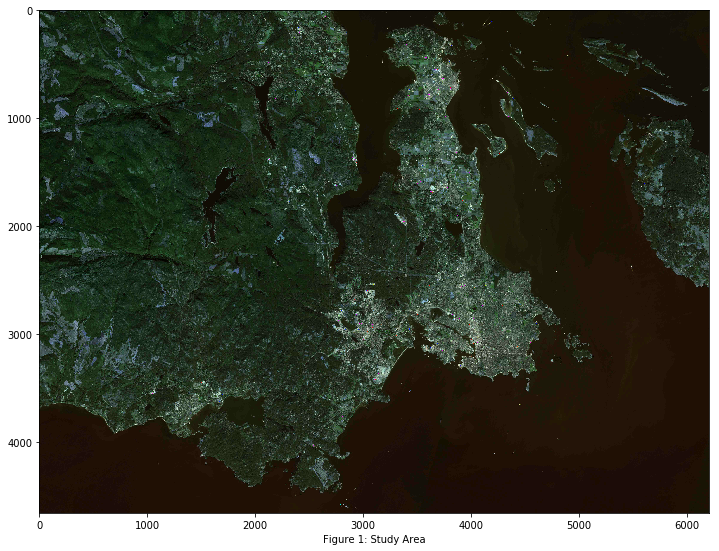

In [2]:
#load and display the data

# Set paths to GeoTiff and figures
tif_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\S2A_0928\\'
#tif_path = 'H:\\ResearchProject\\Working\\S2A_0928\\'
#fig_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\Figures\\'

# Open GeoTiff file
dataset = gdal.Open(tif_path+'S2A_0928_MLE_whole.tif', gdal.GA_ReadOnly)

# Display RGB image with bands 4,3,2 respectively
options_list = ['-ot Byte','-of JPEG', '-b 2', '-b 3', '-b 4', '-scale_2', '-scale_3','-scale_4' ] 
options_string = " ".join(options_list)

gdal.Translate(tif_path+'study_area.jpg', tif_path+'S2A_0928_MLE_whole.tif', options=options_string)
img = plt.imread(tif_path+'study_area.jpg')

plt.figure(1,figsize=(12,12))
plt.xlabel('Figure 1: Study Area')
plt.imshow(img*4) #Brighten image with scalar multiplication

In [3]:
# Save each band from dataset in a 3D array
S2_array = np.zeros((1,1,1))
#print('Descriptive statistics for each band')
stats_all = np.empty([4])
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    array = band.ReadAsArray()
    if x <= 1:
        S2_array = np.array(array)
    else:
        S2_array = np.dstack((S2_array, np.array(array)))
   
    # Save statistics for each band
    stats = band.GetStatistics(True,True)
    stats_all = np.vstack((stats_all,stats))
    
data_bands = dataset.RasterCount
num_bands = data_bands - 2
print('Shape of Dataset')
print(S2_array.shape)
print('Number of bands')
print(data_bands)

Shape of Dataset
(4657, 6205, 13)
Number of bands
13


#### 2.2.1 Data Preprocessing
The remote sensing product was delivered by ESA as a level 1C product which is the top of the atmosphere (TOA) spectral returns which means that the atmospheric moisture (-- other atmospheric issues??--) persist. Therefore, the data required preprocessing using an atmospheric correction algorithm to return the bottom of the atmosphere (BOA) spectral returns. Typically, the data product contains metadata and atmospherical data required for this correction and there are many software packages which could be used to correct this product. The Sen2Cor atmospheric correction provided by ESA was used to correct atmospheric anomolies. It takes information from ... (use the points below)

- AOT - aerosol optical thickness
- WV - water vapor
- Look_UP_Tables selection of the configuration file, three entries: Aerosol_Type, Mid_Latitude and Ozone_Content can be set. The water vapour columns are set internally.
- Haze and cirrus cloud removal (low altitude haze)

As the study area will consist of the Saanich Peninsula and forested regions to the west. Therefore, the orginal tile was trimmed from -- square km -- to --square km --- before processing (Fig.1). A spectral subset was also done to remove bands 11 and 12 from the final product because they are used to perform the atmospheric correction, but are less determinant in land classification. While subsetting the data, spatially and spectrally, to match the 10m resolution the other bands were downsampled to match. The spectral returns for the bands which are 20m and 60m resolution are less important than bands 2, 3, 4, and 8 in the classification of land use. As these bands are within the optical part of the electromagnetic spectrum they interact greatly with the terrestiral features being considered (Fig.2). For example, vegetation interacts heavily with the green, red, and near-infrared parts of the spectrum and water interacts with the near-infrared band.

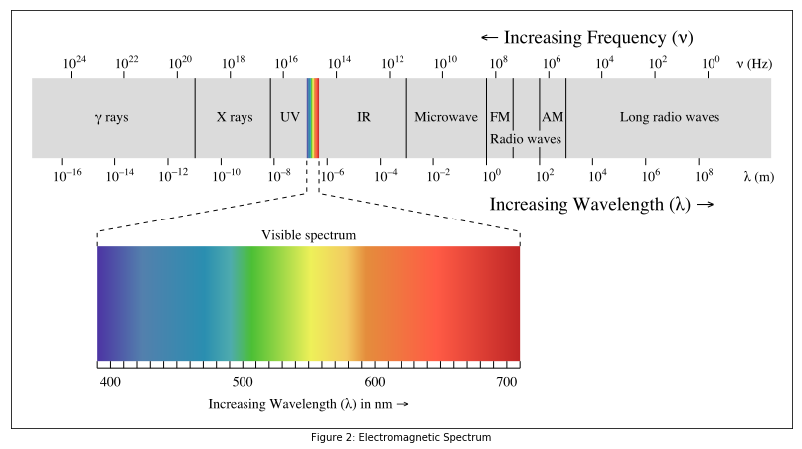

In [4]:
img_spec = plt.imread(tif_path+'EM_spectrum.png')
plt.figure(2, figsize=(14,10))
plt.xlabel('Figure 2: Electromagnetic Spectrum')
plt.xticks([])
plt.yticks([])
plt.imshow(img_spec)

With the use of expert knowledge of the study area homogenous samples were taken for each class. In some cases finding homogenous samples was difficult which leads to an imbalance in the number of pixels collected for each class (Fig.3). In the case of water there are many water bodies clearly visible throughout the scene which are obviously homogenous, so larger sample polygons where created. In the case of grassland, shrub and wet land there were no large homogenous sample to find which lead to a smaller number of pixels chosen. 

The training data include 7 classes: [1 2 3 4 5 6 7]
Class ID 1: Urban
Class ID 2: Forest
Class ID 3: Shrub
Class ID 4: Agriculture
Class ID 5: Grassland
Class ID 6: Wetland
Class ID 7: Water


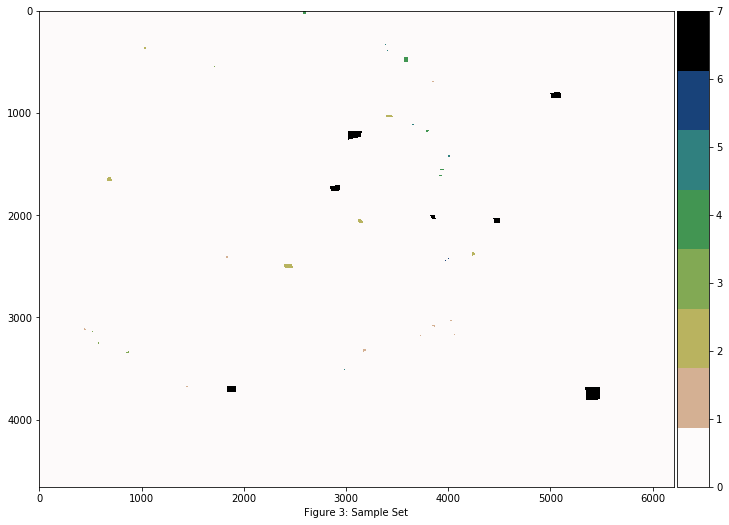

In [5]:
# Extract classification labels from dataset
#!!!CHANGE COLOURS AND SIZE
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sites = S2_array[:,:,11]
S2_image = S2_array[:,:,0:11]
MLE_image = S2_array[:,:,12]
l,w = sites.shape
labels_ID,counts = np.unique(sites[sites>0], return_counts = True)
print('The training data include %d classes: %s'%(labels_ID.size, labels_ID))

# Create dictionary for each class
class_labels = {1:'Urban',2:'Forest',3:'Shrub',4:'Agriculture',5:'Grassland',6:'Wetland',7:'Water'}
for i in labels_ID:
    print('Class ID %d: %s'%(i,class_labels[i]))

# Display training sites
plt.figure(3,figsize=(12,12))
plt.xlabel('Figure 3: Sample Set')
im_sites = plt.imshow(sites, cmap=plt.cm.get_cmap('gist_earth_r', 8))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_sites, cax=cax)

In [6]:
# Prepare sample table
samples = S2_array[:,:,:12]
samples = samples.reshape(l*w,12)
sample_table = samples[samples[:,-1]>0]
ls,ws = sample_table.shape

print('The number of training pixels are: %d'%(ls))
print('The total number of pixels is: %d'%(l*w))
print('The number of urban pixels is: %d'%(counts[0]))
print('The number of forest pixels is: %d'%(counts[1]))
print('The number of shrub pixels is: %d'%(counts[2]))
print('The number of agriculture pixels is: %d'%(counts[3]))
print('The number of grassland pixels is: %d'%(counts[4]))
print('The number of wetland pixels is: %d'%(counts[5]))
print('The number of water pixels is: %d'%(counts[6]))

The number of training pixels are: 63281
The total number of pixels is: 28896685
The number of urban pixels is: 2758
The number of forest pixels is: 9015
The number of shrub pixels is: 676
The number of agriculture pixels is: 3003
The number of grassland pixels is: 1303
The number of wetland pixels is: 298
The number of water pixels is: 46228


Each land classification type has a unique spectral signature which allows the algorithm to determine which class it belongs to (Fig. 4). These spectral signatures need to be seperable in order to classify well. There are two measures of seperability of spectral signatures which were considered when choosing sample data. The bhattacharyya distance and transform divergence measures of signature seperability. For both measures of seperability values greater than 1.8 is considered good seperability. The diagonal of the matrix shows how each class can be seperated from each other, the lower the number the harder it will be to seperate those two classes from one another. A value of 2.0 is perfect seperability.

Bhattacharyya distance is calculated by:

Transformed divergence is calculated by:



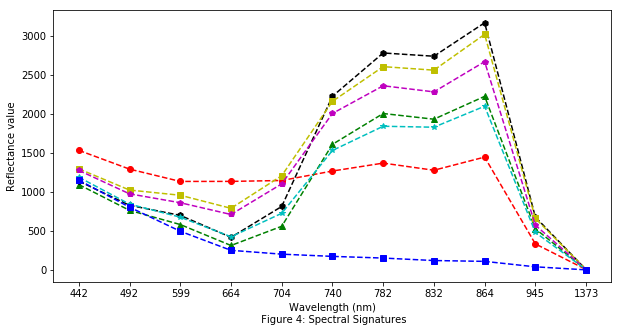

In [7]:
# Extract and display spectral signatures for the 7 classes
#spec_table2 = spec_table[0,:11,1:].T
#labels = spec_table[-1,1:].T
idx = sample_table

idx1 = np.average(idx[idx[:,-1]==1],axis=0)
idx2 = np.average(idx[idx[:,-1]==2],axis=0)
idx3 = np.average(idx[idx[:,-1]==3],axis=0)
idx4 = np.average(idx[idx[:,-1]==4],axis=0)
idx5 = np.average(idx[idx[:,-1]==5],axis=0)
idx6 = np.average(idx[idx[:,-1]==6],axis=0)
idx7 = np.average(idx[idx[:,-1]==7],axis=0)

bandnm = [442,492,599,664,704,740,782,832,864,945,1373]

plt.figure(4,figsize=(10,5))
plt.plot(idx1[:-1], '--ro', idx2[:-1], '--g^', idx3[:-1], '--kh', idx4[:-1], '--ys',
         idx5[:-1], '--mp', idx6[:-1], '--c*', idx7[:-1], '--bs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],[442,492,599,664,704,740,782,832,864,945,1373])
plt.xlabel('Wavelength (nm)\n Figure 4: Spectral Signatures')
plt.ylabel('Reflectance value')
plt.show()

#### 2.2.2 Data Processing
The dataset was prepared by extracting the pixels and bands which match that were used as samples in the PCI software to ensure the same sample sets were used and visually confirmed as the correct land classification. A sample set datatable was created then seperated into training and testing sets. 33% of the sample set was held for testing, this was known to be a good split in --this paper-- [4]. Finally, the 10m resolution GeoTiff remote sensing image was segmented in order to run the prediction models efficiently using scikit-learn as it is 28,896,685 pixels by 11 bands. If this is not done then memory is nearly depleted, and results require hours of time.

In [8]:
# Extract Y_train and X_train from table
ln, wd = sample_table.shape
X = sample_table[:,0:wd-1]
Y = sample_table[:,-1]

X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

print('Testing and training set shape:')
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

print('Image to be classified shape:')
image_class = S2_image.reshape(l*w,num_bands)
print(image_class.shape)

# Divide data into to 4 for faster processing
datLen,fields = image_class.shape 
qt = int(datLen/4)
image_classAa = image_class[:qt,:]
image_classAb = image_class[qt:qt*2,:]
image_classBa = image_class[qt*2:qt*3,:]
image_classBb = image_class[qt*3:,:]

Testing and training set shape:
(18985, 11)
(44296, 11)
(18985,)
(44296,)
Image to be classified shape:
(28896685, 11)


### 2.2 Classification Methods
#### 2.2.1 PCI base classification model
PCI Geomatica is a known remote sensing software with a variety of land classification algorithms available. The maximum likelihood classification model was used which is based on the same theories as the section 2.2.2. Once the samples were selected the spectral signature seperability is calculated using Bhattchayya and distance software tools, and the classification algorithm is performed. Once the model is prepared an accuracy assessment is completed by selecting 40 pixels at random and visually confirming if they were classified correctly by the user. Once this is complete a confusion matrix, accuracy score, average accuracy score, kappa coeffiecent, and --others--?? are output. The classification model itself is output to a band within the dataset, so all the pixels allign and are easily convertable.

In [37]:
# Load data required for accuracy assessment and visualization
# All statistcs come from the classification report output by PCI software
bhat_dist = plt.imread(tif_path+'sig_sep_bhat.jpg')
trans_dive = plt.imread(tif_path+'sig_sep_trans.jpg')

pci_score = 0.9932
pci_score_avg = 0.9738 
pci_con_mx = np.array([[3,0,0,1,0,0,1],[0,9,1,0,0,0,0],[0,3,2,0,0,0,0],[1,0,0,1,1,0,0],
                       [0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,0,0,0,0,0,15]])
pci_kappa = 0.98468  

#### 2.2.2 Recreate Maximum Likelihood Classification
Maximum likelihood estimation (MLE) is a probabilistic model which is based on Bayes theorm. It predicts the probability of each pixels for each class then chooses the classification with the highest likelihood.
The major inputs are a class mean vector and a covariance matrix.

[rewrite]
A parametric statistical model is a collection of probability distribution functions each of which is uniquely characterized by a finite dimensional vector of parameters (θ). For example Gaussian distributions are characterized by their mean and covariance matrix.

Given a dataset and set of models find the set of parameters that maximizes the likelihood of observing the data given the model. In well-behaved cases this estimation can be performed analytically rather than numerically using optimization methods. For example the ML estimate of the mean and covariance matrix are the sample mean and sample covariance.

The likelihood of a set of data for a particular statistical model assumes that the data is i.i.d (independent and identically distributed). That means that:

P(x|M) = Yi P(xi|M) = YiP(xi|θ), (1)

where θ is a vector of parameters characterizing the model M and xi are the data points. If we consider the equation above as a function of the θ for the data point xi we obtain:

L(θ|x1, . . . , xn) = Qi P(xi|θ) (2)

ln (θ|x1, . . . , xn) = ln Qi P(xi|θ) = Pi ln P(xi|θ) (3)

[rewrite]


Using a Gaussian distribution.
Talk about the time and space efficiency.

In [10]:
# Maximum Likelihood Classifier
mle_start = time.time()

mle = GaussianNB()

# Fit the classifier on the training dataset
mle.fit(X_train, Y_train)

mle_fit_t = time.time()

# Predict the classification for each pixel in image
mle_Y_predAa = mle.predict(image_classAa)
mle_Y_predAb = mle.predict(image_classAb)
mle_Y_predBa = mle.predict(image_classBa)
mle_Y_predBb = mle.predict(image_classBb)

mle_pred_t = time.time()

# Check shape of output and reshape to display image
mle_Y_whole = np.append(mle_Y_predAa,mle_Y_predAb)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBa)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBb)
mle_img = mle_Y_whole.reshape(l,w)

# Print the score using the test set data
mle_score = mle.score(X_test,Y_test)

In [11]:
# Calculate time efficiency for MLE
print('The time it took to fit the classification model with the training data: %.6f seconds'%(mle_fit_t-mle_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(mle_pred_t-mle_fit_t))
print('The time it took to run the classification method: %.6f seconds'%(mle_pred_t-mle_start))
print('The number of classes in this image: %s'%(np.unique(mle_Y_whole)))

The time it took to fit the classification model with the training data: 0.104729 seconds
The time it took to predict the image classification matrix: 45.213763 seconds
The time it took to run the classification method: 45.318492 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


#### 2.2.3 Support Vector Machine
- What is a support vector machine

As most literature uses RBF kernel it was considered in this study, but was found to take an excessive amount of time for the scope of this project (over 24 hours for each train and predict cycle). Furthermore, there is no magic formula for the cost and gamma paramters for the RBF kernel, in some literature they use very large gamma of 200-20000 [9] and other literature use very small gamma of 0.0000001-0.0001 [10]. After attempting a variety of cost and gamma values with little improvment in accuracy score or encompasing the entire class system, it was determined that consideration of the linear and polynomial kernel will take precidence. Furthermore, these kernels have not been extensively analyzed.

A variety of regularization and gamma parameters were considered for the linear and polynomial kernels. It was found that the value of the parameters did not greatly affect the accuracy score for the linear kernel; therefore, the regularization parameter chosen was 

There are various types: linear, polynomial, and rbf.
- explain the differences

The different types of kernels for the SVM was analyzed for accuracy and one chosen to compare to the PCI software output.

[rewrite and explain]The complexity of support vector machines increases tremendously with the number of training vectors. At the center of a SVM is a quadratic programming problem which seperates support vectors from training vectors. The scikit-learn SVM library scales between O(n features x n^2 samples) and O(n features x n^3 samples). With extremely large datasets the cannot efficiently use the libsvm cache.

- Find more information from papers.


Trying different kernel types, and regularization parameter (C):
LINEAR kernel works well with C = 0.3.
RBF kernel does not work at all (just continues running for over an hour even after assigning max_iter). Will attempt to change parameters to correct this as research shows it is a common kernel type for land classification models [2].
POLYNOMIAL kernels work well, but wish to improve based on order and regularization parameter.
Moving forward in the accuracy assessment LINEAR kernel is currently being used as a comparison.

In [ ]:
# Try different C and gamma for linear kernel
C_try = [0.1,0.3,0.8,1,3]
gamma_try = [0.01,0.1,0.5,1,1.5]
degree_try = [2,3,4,5]
test_acc_lin = np.zeros([25,3])
test_acc_poly = np.zeros([25,4])
j,k = 0,0
for Ct in C_try:
    for Gt in gamma_try:
        svc_test_lin = svm.SVC(kernel='linear', C = Ct, gamma = Gt) # tried for RBF too
        svc_test_lin.fit(X_train, Y_train)
        svc_lin_test = svc_test_lin.score(X_test,Y_test)
        test_acc_lin[j,0],test_acc_lin[j,1],test_acc_lin[j,2] = Ct,Gt,svc_lin_test
        j+=1
        #for Dt in degree_try:
         #   svc_test_poly = svm.SVC(kernel='poly', degree = Dt, C = Ct, gamma = Gt)
          #  svc_test_poly.fit(X_train, Y_train)
           # svc_poly_test = svc_test_poly.score(X_test,Y_test)
           # test_acc_poly[k,0],test_acc_poly[k,1],test_acc_poly[k,2],test_acc_poly[k,3] = Ct,Gt,Dt,svc_poly_test
           # k+=1
print(test_acc_lin)
print(test_acc_poly)

In [12]:
# SVC - support vector classification
# LINEAR Kernel Test
svc_start = time.time()

svc = svm.SVC(kernel = 'linear', C = .3) 

# Fit the classifier on the training dataset
svc.fit(X_train, Y_train)

svc_fit_t = time.time()

# Predict the classification for each pixel in image
svc_Y_predAa = svc.predict(image_classAa)
svc_Y_predAb = svc.predict(image_classAb)
svc_Y_predBa = svc.predict(image_classBa)
svc_Y_predBb = svc.predict(image_classBb)

svc_pred_t = time.time()

# Check shape of output and reshape to display image
svc_Y_whole = np.append(svc_Y_predAa,svc_Y_predAb)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBa)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBb)
svc_img = svc_Y_whole.reshape(l,w)

# Print the score using the test set data
svc_score = svc.score(X_test,Y_test)

In [13]:
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(svc_fit_t-svc_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(svc_pred_t-svc_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(svc_pred_t-svc_start))
print('The number of classes in this image: %s'%(np.unique(svc_Y_whole)))

The time it took to fit the SVC classification model with the training data: 57.978758 seconds
The time it took to predict the image classification matrix: 359.383312 seconds
The time it took to run the SVC classification method: 417.362071 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


In [14]:
C = 0.3 # regularization parameter - try varying these values
gamma = 5

poly_start_t = time.time()

poly = svm.SVC(kernel="poly", gamma=gamma, degree=3, C=C)

poly.fit(X_train, Y_train)

poly_fit_t = time.time()

# Predict the classification for each pixel in image
poly_Y_predAa = poly.predict(image_classAa)
poly_Y_predAb = poly.predict(image_classAb)
poly_Y_predBa = poly.predict(image_classBa)
poly_Y_predBb = poly.predict(image_classBb)

poly_pred_t = time.time()

# Check shape of output and reshape to display image
poly_Y_whole = np.append(poly_Y_predAa,poly_Y_predAb)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBa)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBb)
poly_img = poly_Y_whole.reshape(l,w)

# Print the score using the test set data
poly_score = poly.score(X_test,Y_test)

In [15]:
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(poly_fit_t-poly_start_t))
print('The time it took to predict the image classification matrix: %.6f seconds'%(poly_pred_t-poly_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(poly_pred_t-poly_start_t))

print('The number of classes in this image: %s'%(np.unique(poly_Y_whole)))

The time it took to fit the SVC classification model with the training data: 35.492831 seconds
The time it took to predict the image classification matrix: 119.469810 seconds
The time it took to run the SVC classification method: 154.962641 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


#### 2.2.4 Neural Network
Neural networks are representative of a biological nervous system where neurons are connected with paths which flow from one to the next, and are interconnected.

The multi-layer perceptron (MLP) is a supervised classification method using a neural network. It learns with a function in the mth dimension and outputs a classification model in the oth dimension. It can train non-linear data by using hidden layers within the network. The first layer is made of neurons which represent the input features and each neuron in the hidden layer is transformed using a weighted summation then a non-linear activation function. MLP uses backpropagation which trains using a form of gradient decent and the Cross-Entropy loss function, giving a vector of probability estimates for each sample.

- what is the weighted summation and the non-linear activation = how do they affect the output.
- capable of learning in realtime

- adam solver chosen for large dataset 
- alpha constrains the weights (bigger less contraint - lower score defualt ok)
- highly dependent on the learning_rate_init
- attempted plane stochastic gradient decent and that did not work, using adam was the best - optimized stochastic gradient decent
Good paper for neural networks:
Neural Network Approaches Versus Statistical Methods in Classification of Multisource Remote Sensing Data 
- distribution free
- no prior knowledge of class probabilities required like MLE or SVM
- found no improvement after 32 nodes within the single hidden layer

Similar to the literature having more than one hidden layer did not improve accuracy.

In [ ]:
# Analyze the accuracy for different number of nodes in a single hidden layer
# looking for trends
nnt=[]
nnid=[]
for xyz in range (1,65):
    nn_test = MLPClassifier(hidden_layer_sizes=(xyz,),activation ='tanh')
    nn_test_id = MLPClassifier(hidden_layer_sizes=(xyz,),activation ='identity')
    nn_test.fit(X_train,Y_train)
    nn_test_id.fit(X_train,Y_train)
    t=nn_test.score(X_test,Y_test),
    tid=nn_test_id.score(X_test,Y_test)
    nnt.append(t)
    nnid.append(tid)
   # print('Node %d \t TANH score %.6f \t IDENTITY score %.6f'%(xyz,nn_test.score(X_test,Y_test),
                                                              #nn_test_id.score(X_test,Y_test)))

    plt.figure(5,figsize=(10,5))
plt.plot(nnt[1:],'--ro',nnid[1:],'--gs')
plt.xlabel('Number of nodes in single hidden layer\n Figure 5: Accuracy scores for varying neural network nodes.')
plt.ylabel('Accuracy Scores')
plt.show()

In [17]:
# Neural Network from scikit - learn
# TAHN activation
nn_start = time.time()

nn = MLPClassifier(hidden_layer_sizes=(55,),activation='tanh')

# Fit the classifier on the training dataset
nn.fit(X_train, Y_train)

nn_fit_t = time.time()

# Predict the classification for each pixel in image
nn_Y_predAa = nn.predict(image_classAa)
nn_Y_predAb = nn.predict(image_classAb)
nn_Y_predBa = nn.predict(image_classBa)
nn_Y_predBb = nn.predict(image_classBb)

nn_pred_t = time.time()

nn_Y_whole = np.append(nn_Y_predAa,nn_Y_predAb)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBa)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBb)
nn_img = nn_Y_whole.reshape(l,w)

nn_score = nn.score(X_test,Y_test)

In [18]:
# Calculate time and space efficency for NN
print('The time it took to fit the NN classification model with the training data: %.6f seconds'%(nn_fit_t-nn_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(nn_pred_t-nn_fit_t))
print('The time it took to run the NN classification method: %.6f seconds'%(nn_pred_t-nn_start))
print('The number of classes in this image: %s'%(np.unique(nn_Y_whole)))

The time it took to fit the NN classification model with the training data: 3.051857 seconds
The time it took to predict the image classification matrix: 29.100169 seconds
The time it took to run the NN classification method: 32.152027 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


In [19]:
# IDENTITY activation
nn_start = time.time()

nnID = MLPClassifier(hidden_layer_sizes=(30,), activation='identity')

# Fit the classifier on the training dataset
nnID.fit(X_train, Y_train)

nn_fit_t = time.time()

# Predict the classification for each pixel in image
nn_Y_predAa = nnID.predict(image_classAa)
nn_Y_predAb = nnID.predict(image_classAb)
nn_Y_predBa = nnID.predict(image_classBa)
nn_Y_predBb = nnID.predict(image_classBb)

nn_pred_t = time.time()

nn_Y_whole = np.append(nn_Y_predAa,nn_Y_predAb)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBa)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBb)
nnID_img = nn_Y_whole.reshape(l,w)

nnID_score = nnID.score(X_test,Y_test)

In [20]:
# Calculate time and space efficency for NN
print('The time it took to fit the NN classification model with the training data: %.6f seconds'%(nn_fit_t-nn_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(nn_pred_t-nn_fit_t))
print('The time it took to run the NN classification method: %.6f seconds'%(nn_pred_t-nn_start))
print('The number of classes in this image: %s'%(np.unique(nnID_img)))

The time it took to fit the NN classification model with the training data: 18.020212 seconds
The time it took to predict the image classification matrix: 15.867248 seconds
The time it took to run the NN classification method: 33.887460 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


#### 2.2.6 Algorithm Accuracy Assessment 
Each algorithm requires individual assessment before being compared to eachother and the PCI base case classification model. Therefore, based on similar studies, there were various accuracy tests conducted. These include: the scikit-learn built in accuracy score, the confusion matrix and its calculated accuracy score, stratified cross validation mean accuracy score, the kappa coefficient, precision, recall, F-measure, and the Producer's and User's accuracy scores. Some of these accuracy measurements come from the field of machine learning while other come from the field of geography.

First the built in scikit-learn score function was compared to the accuracy score calculated from the confustion matrix.  The accuracy score determined with the scikit learn library score function takes the test set, 30% of training sites where the classification is known, and compares them to the algorithm's actual output. It then returns the mean accuracy value for all classes. A confustion matrix is a particularly useful visualization and calculation tool for multiple accuracy statistics and overal accuracy assessment. Paritcularly it represents the best way to determine errors of commission and emission alongside correct classification. The confusion matrix also takes in the same test set and each instance is counted once. The values appearing in the diagonal of the matrix represent the correctly classified pixels and the values outside of this diagonal represent the values which were misclassified. The sum of the diagonal divided by the total sum of pixels in the confusion matrix is the final accruacy score.

As the above scores only take into account the test set which is sufficiently randomized, it does not take into account that the number of pixels for each class in the sample set is not evenly distributed. For this reason stratified cross validation was considered using 10 folds to determine the average accuracy score based on different training and test sets. Stratificiation will more evenly distribute the training and test classes across all 7 possible classes instead of skewing the data toward a single class. For example, since the water class has much more sample pixels when compared to grassland or wetland the algorithm could be trained very well for water but not as good for other classes. Stratified cross validation will prevent this from happening. 

Another accuracy statistics which can be extracted from the confusion matrix is the Producer's and User's accuracy which represents the accuracy of each individual class. The Producer's accuracy is based on the reference data and the User's accuracy is based on the classified data. -- EXPLAIN MORE --. The Producer's accuracy is easily calculated by taking the number of correctly classified pixels for each class and dividing it by the sum of the pixels within that classes column. Similarly, the User's accuracy is calculated by taking the number of correctly classified pixels and dividing it by the sum of the pixels within that row.

The kappa coeffient considers how the overall accuracy compares to what would be expected at random; that is, it compares the percentage improvement of the algorithm to a purely random assignment of classes to the model. -- why is this important or used--. Perfect agreement with random obtains a value of positive one, zero is obtained when there is no agreement above what was randomly assigned, and complete disagreement is obtained with negative one.
- good for kappa: Comparison between Possibilistic c-Means (PCM) and Artificial Neural Network (ANN) Classification Algorithms in Land use/ Land cover Classification 

So it measures the percentage improvement by the classifier over a purely random assignment of classes to the image pixels. The possible Kappa values range from +1 (perfect agreement) to 0 (no agreement above that expected by chance) to -1(complete disagreement). Therefore, it is a quantification to determine if the algorithm's model is significantly different than random. 

Finally, precision, recall, and F-measure are considered. As there is a trade off between precision and recall the F-measure is used to balance the two. Precision is a measure of how exact the classification model is, and recall is 
- Need to finish!

In [21]:
# Calculate and save the accuracy values here to display in results

# Calculate the confusion matrix for each classification method and display side by side
mle_test = mle.predict(X_test)
svc_test = svc.predict(X_test)
poly_test = poly.predict(X_test)
nn_test = nn.predict(X_test)
nnID_test = nnID.predict(X_test)

# MLE confusion matrix
mle_con_mx = confusion_matrix(Y_test, mle_test)
# SVC confusion matrix
svc_con_mx = confusion_matrix(Y_test, svc_test)
poly_con_mx = confusion_matrix(Y_test, poly_test)
# Neural network confusion matrix
nn_con_mx = confusion_matrix(Y_test, nn_test)
nnID_con_mx = confusion_matrix(Y_test, nnID_test)

# Calculate accuracy score based on (diagonal /total samples)
mle_diag = np.diag(mle_con_mx)
svc_diag = np.diag(svc_con_mx)
poly_diag = np.diag(poly_con_mx)
nn_diag = np.diag(nn_con_mx)
nnID_diag = np.diag(nnID_con_mx)
pci_diag = np.diag(pci_con_mx)
            
acc_mle = np.sum(mle_diag)/np.sum(mle_con_mx)
acc_svc = np.sum(svc_diag)/np.sum(svc_con_mx)
acc_poly = np.sum(poly_diag)/np.sum(poly_con_mx)
acc_nn = np.sum(nn_diag)/np.sum(nn_con_mx)
acc_nnID = np.sum(nnID_diag)/np.sum(nnID_con_mx)

In [25]:
# Calculate the Producer's (column) and User's (row) Accuracy for each class
mle_prod = np.round((mle_diag/np.sum(mle_con_mx,axis=0))*100,4)
mle_user = np.round((mle_diag/np.sum(mle_con_mx,axis=1))*100,4)

svc_prod = np.round((svc_diag/np.sum(svc_con_mx,axis=0))*100,4)
svc_user = np.round((svc_diag/np.sum(svc_con_mx,axis=1))*100,4)
poly_prod = np.round((poly_diag/np.sum(poly_con_mx,axis=0))*100,4)
poly_user = np.round((poly_diag/np.sum(poly_con_mx,axis=1))*100,4)

nn_prod = np.round((nn_diag/np.sum(nn_con_mx,axis=0))*100,4)
nn_user = np.round((nn_diag/np.sum(nn_con_mx,axis=1))*100,4)
nnID_prod = np.round((nnID_diag/np.sum(nnID_con_mx,axis=0))*100,4)
nnID_user = np.round((nnID_diag/np.sum(nnID_con_mx,axis=1))*100,4)

pci_prod = np.round((pci_diag/np.sum(pci_con_mx,axis=0))*100,4)
pci_user = np.round((pci_diag/np.sum(pci_con_mx,axis=1))*100,4)

C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [27]:
# Kappa score 
mle_kappa = kappa(Y_test, mle_test, weights=None, allow_off_by_one=False)
svc_kappa = kappa(Y_test, svc_test, weights=None, allow_off_by_one=False)
poly_kappa = kappa(Y_test, poly_test, weights=None, allow_off_by_one=False)
nn_kappa = kappa(Y_test, nn_test, weights=None, allow_off_by_one=False)
nnID_kappa = kappa(Y_test, nnID_test, weights=None, allow_off_by_one=False)

In [26]:
# Calculate F-measure, precision, and recall 
warnings.filterwarnings('ignore')

p_mle, r_mle, f_mle, s_mle = precision_recall_fscore_support(Y_test,mle_test)
p_mle,r_mle,f_mle = p_mle.round(decimals = 4),r_mle.round(decimals = 4),f_mle.round(decimals = 4)

p_svc, r_svc, f_svc, s_svc = precision_recall_fscore_support(Y_test,svc_test)
p_svc,r_svc,f_svc = p_svc.round(decimals = 4),r_svc.round(decimals = 4),f_svc.round(decimals = 4)
p_poly, r_poly, f_poly, s_poly = precision_recall_fscore_support(Y_test,poly_test)
p_poly,r_poly,f_poly = p_poly.round(decimals = 4),r_poly.round(decimals = 4),f_poly.round(decimals = 4)

p_nn, r_nn, f_nn, s_nn = precision_recall_fscore_support(Y_test,nn_test)
p_nn,r_nn,f_nn = p_nn.round(decimals = 4),r_nn.round(decimals = 4),f_nn.round(decimals = 4)
p_nnID, r_nnID, f_nnID, s_nnID = precision_recall_fscore_support(Y_test,nnID_test)
p_nnID,r_nnID,f_nnID = p_nnID.round(decimals = 4),r_nnID.round(decimals = 4),f_nnID.round(decimals = 4)

In [28]:
# Be rid of warnings for the precision, recall, and f-measure function calls
# Perform stratified k-fold cross validation

# function from https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

# Perform Stratified k-fold cross validation
shuffle = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scoring = ['precision_macro','recall_macro','accuracy','f1_macro']
scores_mle_all, scores_svc_all, scores_poly_all, scores_nn_all, scores_nnID_all = {},{},{},{},{}
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, Y):
    scores_mle = cross_validate(mle, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_mle_all = merge_two_dicts(scores_mle_all, scores_mle)
    
    scores_svc = cross_validate(svc, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_svc_all = merge_two_dicts(scores_svc_all, scores_svc)
    scores_poly = cross_validate(poly, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_poly_all = merge_two_dicts(scores_poly_all, scores_poly)
    
    scores_nn = cross_validate(nn, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_nn_all = merge_two_dicts(scores_nn_all, scores_nn)
    scores_nnID = cross_validate(nnID, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_nnID_all = merge_two_dicts(scores_nnID_all, scores_nnID)

#### 2.2.7 Statistical Comparison between Algorithms and to base
Following the individual algorithm accuracy assessment the best SVM and NN were chosen out of the two considered, and the between algorithm comparison was done. It was conducted using the McNemar test which considers the errors in classification and the level of disagreement between each algorithm. If two MLA disagree in the same way then the statistic returned will show a significant difference, if the two MLA have a skewed disagreement then the statistic will show no significant different. This test takes advantage of -- paper??? two tail something Chi square -- to calculate a p-value of statistical significance. The levels of disagreement are obtained using a contingency table outlined in Table 3 which requires binary metrics of True or False values based on correctly or incorrectly classified pixels.

Table 3: Contingency table example.

|MLA  |MLA 2                |MLA 2         |
|-----|---------------------|--------------|
|MLA 1|     True/True       | True/False   |
|MLA 1|     False/True      |False/False   |

In [29]:
# Use this loop for McNemar comparison
mcnemar_table = np.zeros([ls,4])
idx = 0

# Create a binary table of True and falsely classified pixels
for i in range(l):
    for j in range(w):   
        cl = sites[i,j]
        if cl>0:
            if mle_img[i,j] == cl:
                mcnemar_table[idx,0] = 1
            if poly_img[i,j] == cl:
                mcnemar_table[idx,1] = 1
            if nn_img[i,j] == cl:
                mcnemar_table[idx,2] = 1
            if MLE_image[i,j] == cl:
                mcnemar_table[idx,3] = 1
            idx +=1

In [30]:
# Create Contingency Table from binary table
ms_tp, ms_fp, ms_tn, ms_fn = 0,0,0,0
mp_tp, mp_fp, mp_tn, mp_fn = 0,0,0,0
mn_tp, mn_fp, mn_tn, mn_fn = 0,0,0,0
sp_tp, sp_fp, sp_tn, sp_fn = 0,0,0,0
sn_tp, sn_fp, sn_tn, sn_fn = 0,0,0,0
np_tp, np_fp, np_tn, np_fn = 0,0,0,0

# Extract the True/False and False/True portions of the table
ms_bin = mcnemar_table[:,0]-mcnemar_table[:,1]
ms_fp = np.absolute(np.sum(ms_bin[ms_bin==1]))
ms_fn = np.absolute(np.sum(ms_bin[ms_bin==-1]))

mp_bin = mcnemar_table[:,0]-mcnemar_table[:,3]
mp_fp = np.absolute(np.sum(mp_bin[mp_bin==1]))
mp_fn = np.absolute(np.sum(mp_bin[mp_bin==-1]))

mn_bin = mcnemar_table[:,0]-mcnemar_table[:,2]
mn_fp = np.absolute(np.sum(mn_bin[mn_bin==1]))
mn_fn = np.absolute(np.sum(mn_bin[mn_bin==-1]))

sp_bin = mcnemar_table[:,1]-mcnemar_table[:,3]
sp_fp = np.absolute(np.sum(sp_bin[sp_bin==1]))
sp_fn = np.absolute(np.sum(sp_bin[sp_bin==-1]))

sn_bin = mcnemar_table[:,1]-mcnemar_table[:,2]
sn_fp = np.absolute(np.sum(sn_bin[sn_bin==1]))
sn_fn = np.absolute(np.sum(sn_bin[sn_bin==-1]))

np_bin = mcnemar_table[:,2]-mcnemar_table[:,3]
np_fp = np.absolute(np.sum(np_bin[np_bin==1]))
np_fn = np.absolute(np.sum(np_bin[np_bin==-1]))

# Extract True/True and False/False
for mi in mcnemar_table:
    # mle vs svc
    if mi[0]==1 and mi[1]==1:
        ms_tp +=1
    if mi[0]==0 and mi[1]==0:
        ms_tn += 1
     # mle vs nn
    if mi[0]==1 and mi[2]==1:
        mn_tp +=1
    if mi[0]==0 and mi[2]==0:
        mn_tn += 1
     # mle vs pci
    if mi[0]==1 and mi[3]==1:
        mp_tp +=1
    if mi[0]==0 and mi[3]==0:
        mp_tn += 1
     # svc vs nn
    if mi[1]==1 and mi[2]==1:
        sn_tp +=1
    if mi[1]==0 and mi[2]==0:
        sn_tn += 1
     # svc vs pci
    if mi[1]==1 and mi[3]==1:
        sp_tp +=1
    if mi[1]==0 and mi[3]==0:
        sp_tn += 1
    # nn vs pci
    if mi[2]==1 and mi[3]==1:
        np_tp +=1
    if mi[2]==0 and mi[3]==0:
        np_tn += 1

## 3. Results and Discussion
### 3.1 Descriptive Statistics and Signature Seperability measures
Descriptive statistics for each spectral band from the dataset will vary depending on the band due to the part of the electromagnetic spectrum it is measuring. They were used to ensure that there were no erroneous values or any bands which should not be considered due to preprocessing errors.

It was determined with the signature seperability that the samples chosen were sufficient to use for classification. A minimum measure over 1.86 for the bhattacharyya distance, and over 1.95 for the transformed divergence is above the required 1.8 which determines suitable seperability. Each seperabilty measure determined difference classes which would be difficult to seperate. Bhattacharyya distance determined that shrub and wetland would be the most difficult to seperate, and transformed divergence determined that forest and shrub would be the most difficult. It may be possible that these classes may have more classification errors than other classes.

Band #1: Minimum=0.000, Maximum=0.000, Mean=719.625, Standard Deviation=551.897
Band #2: Minimum=1008.000, Maximum=2573.000, Mean=1160.923, Standard Deviation=78.239
Band #3: Minimum=656.000, Maximum=6087.000, Mean=832.732, Standard Deviation=111.000
Band #4: Minimum=393.000, Maximum=5761.000, Mean=597.282, Standard Deviation=158.194
Band #5: Minimum=198.000, Maximum=7323.000, Mean=365.727, Standard Deviation=197.341
Band #6: Minimum=157.000, Maximum=6220.000, Mean=483.101, Standard Deviation=301.141
Band #7: Minimum=121.000, Maximum=6526.000, Mean=978.969, Standard Deviation=790.413
Band #8: Minimum=119.000, Maximum=6788.000, Mean=1169.910, Standard Deviation=1002.647
Band #9: Minimum=86.000, Maximum=7795.000, Mean=1122.960, Standard Deviation=1021.890
Band #10: Minimum=71.000, Maximum=7501.000, Mean=1284.588, Standard Deviation=1155.643
Band #11: Minimum=29.000, Maximum=1701.000, Mean=303.167, Standard Deviation=252.365


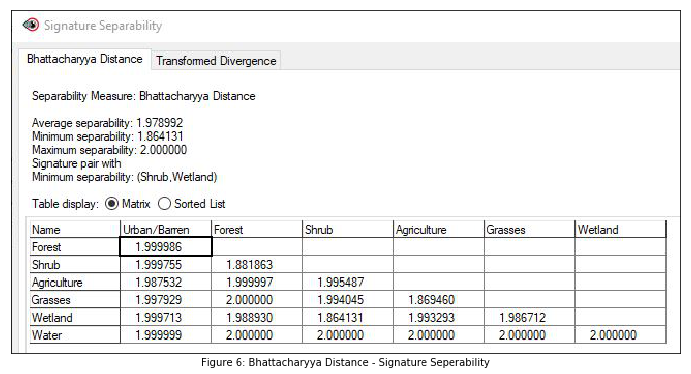

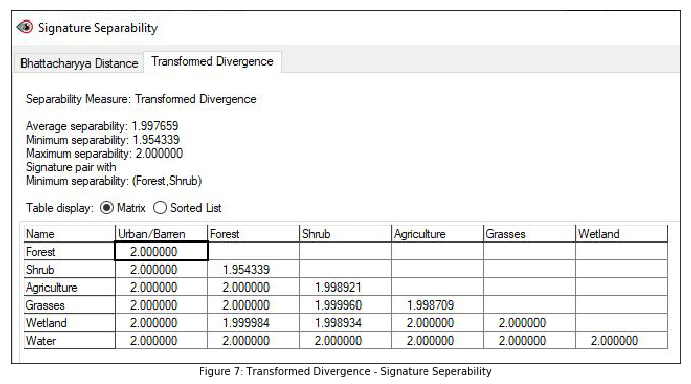

In [38]:
# Print descriptive statistics for each band
numB = 0
for numB in range(0,11):
    print("Band #%d: Minimum=%.3f, Maximum=%.3f, Mean=%.3f, Standard Deviation=%.3f"%(numB+1,stats_all[numB,0],
                                                                                      stats_all[numB,1], 
                                                                                      stats_all[numB,2],
                                                                                      stats_all[numB,3]))
    numB += 1
    
plt.figure(6, figsize=(12,12))
plt.xlabel('Figure 6: Bhattacharyya Distance - Signature Seperability')
plt.xticks([])
plt.yticks([])
plt.imshow(bhat_dist)

plt.figure(7, figsize=(12,12))
plt.xlabel('Figure 7: Transformed Divergence - Signature Seperability')
plt.xticks([])
plt.yticks([])
plt.imshow(trans_dive)

### 3.2 Algorithm Accuracy Assessment
Upon visual inspection of the whole classification model there are differences between --- , but --- are quite similar. The NN does seem to distigush between ----
Each of the models contains each of the seven classes. 

Looking at a subset of the study area over the more densly populated area determines----
It was determined that the accuracy score calculated with the score function in the scikit-learn library was identical to the accuracy score calcuated using the confusion matrix

Place accuracy score with plot!!!!

In [39]:
# Difference in accuracy scores 
func_scores = np.array([mle_score,svc_score,poly_score,nn_score,nnID_score])
acc_scores = np.array([acc_mle,acc_svc,acc_poly,acc_nn,acc_nnID])
print(func_scores - acc_scores)

[0. 0. 0. 0. 0.]


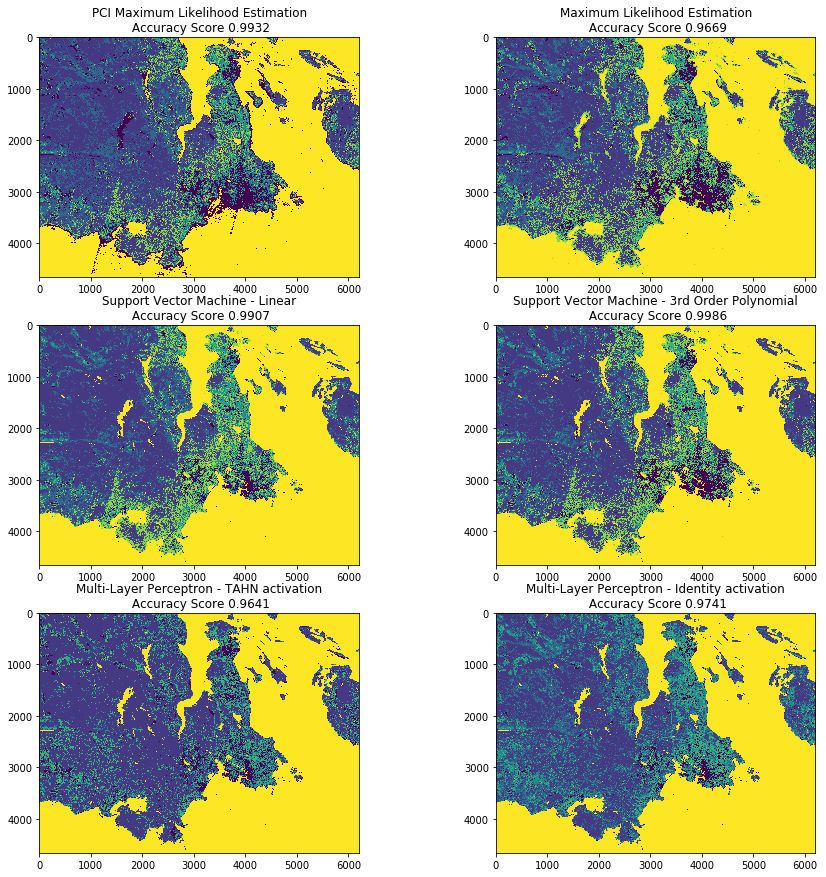

In [40]:
# Display all land classification maps considered 
# !!!!! Kappa Accuracy Scores

plt.figure(8, figsize=(15,15))
plt.subplot(321)
plt.title('PCI Maximum Likelihood Estimation\n Accuracy Score %.4f'%(pci_score))
plt.imshow(MLE_image)

plt.subplot(322)
plt.title('Maximum Likelihood Estimation\n Accuracy Score %.4f'%(mle_score))
plt.imshow(mle_img)

plt.subplot(323)
plt.title('Support Vector Machine - Linear\n Accuracy Score %.4f'%(svc_score))
plt.imshow(svc_img)

plt.subplot(324)
plt.title('Support Vector Machine - 3rd Order Polynomial\n Accuracy Score %.4f'%(poly_score))
plt.imshow(poly_img)

plt.subplot(325)
plt.title('Multi-Layer Perceptron - TAHN activation\n Accuracy Score %.4f'%(nn_score))
plt.imshow(nn_img)

plt.subplot(326)
plt.title('Multi-Layer Perceptron - Identity activation\n Accuracy Score %.4f'%(nnID_score))
plt.imshow(nnID_img)

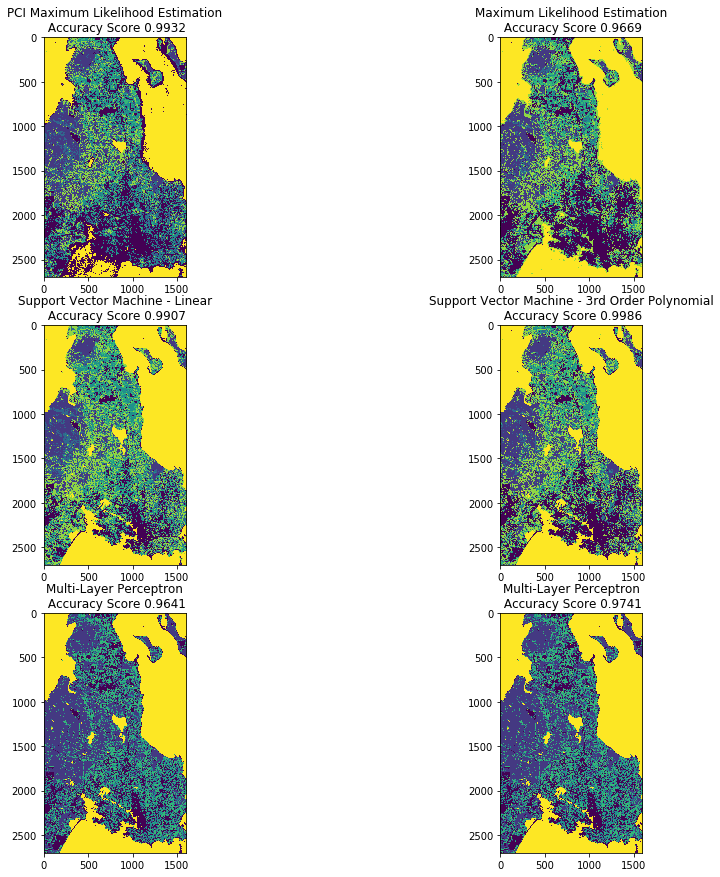

In [41]:
# Display zoomed in section of the pennisula
plt.figure(9, figsize=(15,15))
plt.subplot(321)
plt.title('PCI Maximum Likelihood Estimation\n Accuracy Score %.4f'%(pci_score))
plt.imshow(MLE_image[800:3500,3000:4600])

plt.subplot(322)
plt.title('Maximum Likelihood Estimation\n Accuracy Score %.4f'%(mle_score))
plt.imshow(mle_img[800:3500,3000:4600])

plt.subplot(323)
plt.title('Support Vector Machine - Linear\n Accuracy Score %.4f'%(svc_score))
plt.imshow(svc_img[800:3500,3000:4600])

plt.subplot(324)
plt.title('Support Vector Machine - 3rd Order Polynomial\n Accuracy Score %.4f'%(poly_score))
plt.imshow(poly_img[800:3500,3000:4600])

plt.subplot(325)
plt.title('Multi-Layer Perceptron\n Accuracy Score %.4f'%(nn_score))
plt.imshow(nn_img[800:3500,3000:4600])

plt.subplot(326)
plt.title('Multi-Layer Perceptron\n Accuracy Score %.4f'%(nnID_score))
plt.imshow(nn_img[800:3500,3000:4600])

Talk about the confusion matrix and what they mean, how to interpret them!!

In [42]:
print('PCI Maximum Likelihood Estimation\n 40 Random Samples')
print(pci_con_mx)
print()
print('Maximum Likelihood Estimation')
print(mle_con_mx)
print()
print('Support Vector Machine - Linear')
print(svc_con_mx)
print()
print('Support Vector Machine - 3rd Order Polynomial')
print(poly_con_mx)
print()
print('Neural Network - Tahn Activation')
print(nn_con_mx)
print()
print('Neural Network - Identity Acitvation')
print(nnID_con_mx)
print()

PCI Maximum Likelihood Estimation
 40 Random Samples
[[ 3  0  0  1  0  0  1]
 [ 0  9  1  0  0  0  0]
 [ 0  3  2  0  0  0  0]
 [ 1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0]
 [ 0  0  0  0  0  0 15]]

Maximum Likelihood Estimation
[[  694     0     0    99     0    37     0]
 [    0  2548   129     0     0    11     0]
 [    0     2   173     0    10    23     0]
 [  181     0     0   697    35     0     0]
 [    9     0    21    33   329     0     0]
 [    0    11    20     3     4    46     0]
 [    0     0     0     0     0     0 13870]]

Support Vector Machine - Linear
[[  805     0     0    25     0     0     0]
 [    0  2688     0     0     0     0     0]
 [    0     8   194     1     0     5     0]
 [   50     0     3   837    23     0     0]
 [    1     0     3    43   345     0     0]
 [    0     0    13     0     1    70     0]
 [    0     0     0     0     0     0 13870]]

Support Vector Machine - 3rd Order Polynomial
[[  830     0     0     0     0    

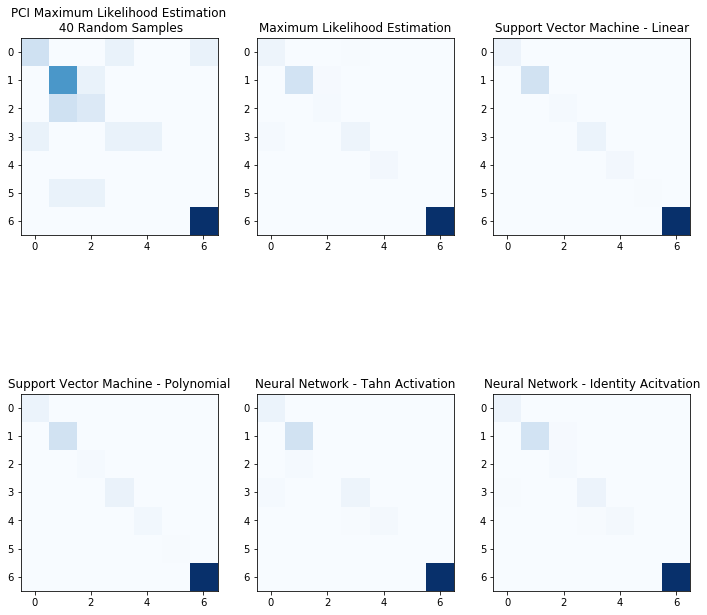

In [43]:
plt.figure(10, figsize=(12,12))
 
i=1
plt.subplot(2,3,i)
plt.title('PCI Maximum Likelihood Estimation\n 40 Random Samples')
plt.imshow(pci_con_mx, cmap="Blues")
    
plt.subplot(2,3,i+1)
plt.title('Maximum Likelihood Estimation')
plt.imshow(mle_con_mx, cmap="Blues")
    
plt.subplot(2,3,i+2)
plt.title('Support Vector Machine - Linear')
plt.imshow(svc_con_mx, cmap="Blues")
   
plt.subplot(2,3,i+3)
plt.title('Support Vector Machine - Polynomial')
plt.imshow(poly_con_mx, cmap="Blues")
    
plt.subplot(2,3,i+4)
plt.title('Neural Network - Tahn Activation')
plt.imshow(nn_con_mx, cmap="Blues")
    
plt.subplot(2,3,i+5)
plt.title('Neural Network - Identity Acitvation')
plt.imshow(nnID_con_mx, cmap="Blues")

Talk about the producer's and user's accuracy for each algorithm

In [44]:
# Calculate Producer's and User's Accuracy from the confusion matrix
# Calculate accuracy score from confusion matrix
print('PCI Maximum Likelihood Estimation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(pci_prod,4),np.round(pci_user,4)))
print('Maximum Likelihood Estimation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(mle_prod,4),np.round(mle_user,4)))
print('Support Vector Machine - Linear')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(svc_prod,4),np.round(svc_user,4)))
print('Support Vector Machine - Polynomial')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(poly_prod,4),np.round(poly_user,4)))
print('Neural Network - Tahn Activation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(nn_prod,4),np.round(nn_user,4)))
print('Neural Network - Identity Activation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(nnID_prod,4),np.round(nnID_user,4)))

PCI Maximum Likelihood Estimation
Producer's Accuracy is: 
[75.     69.2308 50.     50.      0.         nan 93.75  ]
 User's Accuracy is: 
[ 60.      90.      40.      33.3333      nan   0.     100.    ]

Maximum Likelihood Estimation
Producer's Accuracy is: 
[ 78.5068  99.4924  50.4373  83.774   87.037   39.3162 100.    ]
 User's Accuracy is: 
[ 83.6145  94.7917  83.1731  76.3417  83.9286  54.7619 100.    ]

Support Vector Machine - Linear
Producer's Accuracy is: 
[ 94.0421  99.7033  91.0798  92.3841  93.4959  93.3333 100.    ]
 User's Accuracy is: 
[ 96.988  100.      93.2692  91.6758  88.0102  83.3333 100.    ]

Support Vector Machine - Polynomial
Producer's Accuracy is: 
[ 99.8797  99.8884  94.4444  99.1295  99.7389  98.7013 100.    ]
 User's Accuracy is: 
[100.      99.9256  98.0769  99.7809  97.449   90.4762 100.    ]

Neural Network - Tahn Activation
Producer's Accuracy is: 
[ 80.117   89.9698  50.      86.2872  79.2683   0.     100.    ]
 User's Accuracy is: 
[ 99.0361  99.7768

The warnings for the precision, recall, and f-measure come from the lack of samples for a certain class within the training set. Which means that certain test sets are missing a class. 

In [45]:
# Consider the F-Measure, recall, and precision
# Determine which classes are missing for test sets
print('MLE missing class: %s'%(set(Y_test)-set(mle_test)))
print('SVC missing class: %s'%(set(Y_test)-set(svc_test)))
print('NN missing class: %s\n'%(set(Y_test)-set(nn_test)))

print('Maximum Likelihood Estimation')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_mle,r_mle,f_mle))

print('Support Vector Machine - Linear')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_svc,r_svc,f_svc))
print('Support Vector Machine - 3rd Order Polynomail')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_poly,r_poly,f_poly))

print('Neural Network - Tahn Activation')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_nn,r_nn,f_nn))
print('Neural Network - Identity Activation')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_nnID,r_nnID,f_nnID))

MLE missing class: set()
SVC missing class: set()
NN missing class: set()

Maximum Likelihood Estimation
Precision:
[0.7851 0.9949 0.5044 0.8377 0.8704 0.3932 1.    ]
 Recall:
[0.8361 0.9479 0.8317 0.7634 0.8393 0.5476 1.    ]
 F-Measure
[0.8098 0.9709 0.6279 0.7989 0.8545 0.4577 1.    ]

Support Vector Machine - Linear
Precision:
[0.9404 0.997  0.9108 0.9238 0.935  0.9333 1.    ]
 Recall:
[0.9699 1.     0.9327 0.9168 0.8801 0.8333 1.    ]
 F-Measure
[0.9549 0.9985 0.9216 0.9203 0.9067 0.8805 1.    ]

Support Vector Machine - 3rd Order Polynomail
Precision:
[0.9988 0.9989 0.9444 0.9913 0.9974 0.987  1.    ]
 Recall:
[1.     0.9993 0.9808 0.9978 0.9745 0.9048 1.    ]
 F-Measure
[0.9994 0.9991 0.9623 0.9945 0.9858 0.9441 1.    ]

Neural Network - Tahn Activation
Precision:
[0.8012 0.8997 0.5    0.8629 0.7927 0.     1.    ]
 Recall:
[0.9904 0.9978 0.0096 0.7306 0.6633 0.     1.    ]
 F-Measure
[0.8858 0.9462 0.0189 0.7912 0.7222 0.     1.    ]

Neural Network - Identity Activation
Precisi

Maximum Likelihood Estimation Mean Accuracy: 0.9780
Support Vector Machine - Linear - Mean Accuracy: 0.9951
Support Vector Machine - Polynomial - Mean Accuracy: 1.0000
Neural Network - Tahn - Mean Accuracy: 0.9635
Neural Network - Identity- Mean Accuracy: 0.9702


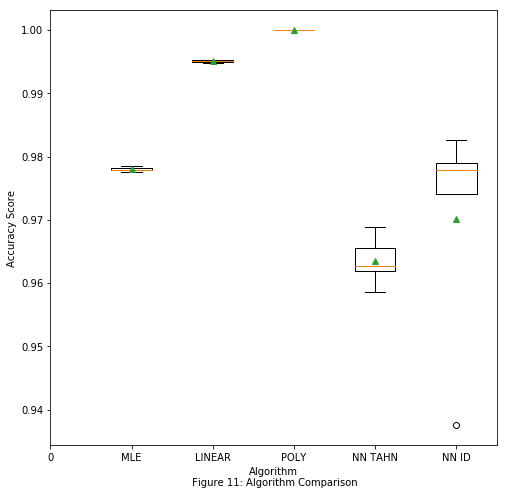

In [46]:
# Dispaly cross validation data

mle_cross = scores_mle_all['train_accuracy']
svc_cross = scores_svc_all['train_accuracy']
poly_cross = scores_poly_all['train_accuracy']
nn_cross = scores_nn_all['train_accuracy']
nnID_cross = scores_nnID_all['train_accuracy']

print('Maximum Likelihood Estimation Mean Accuracy: %.4f'%(np.average(mle_cross)))
print('Support Vector Machine - Linear - Mean Accuracy: %.4f'%(np.average(svc_cross)))
print('Support Vector Machine - Polynomial - Mean Accuracy: %.4f'%(np.average(poly_cross)))
print('Neural Network - Tahn - Mean Accuracy: %.4f'%(np.average(nn_cross)))
print('Neural Network - Identity- Mean Accuracy: %.4f'%(np.average(nnID_cross)))

plt.figure(11,figsize=(8,8))
plt.boxplot([mle_cross,svc_cross,poly_cross,nn_cross,nnID_cross], showmeans = True)
plt.xticks([0,1,2,3,4,5],[0,'MLE','LINEAR','POLY','NN TAHN','NN ID',])
plt.xlabel('Algorithm\n Figure 11: Algorithm Comparison')
plt.ylabel('Accuracy Score')
plt.show()

## 3.7 Comparison Between Algorithms and against PCI Maximum Likelihood Estimation

Consider the overall accuracy scores determined above, and perform the McNemar Test to get a statistical difference between each land classification map.
MLE and NN Tahn are not significantly different in their errors.

Comparison between PCI MLE and scikit-learn MLE
McNemar statistic=1531.082, p-value=0.000000
Contingency Table  [61078, 86.0] 
		   [1775.0, 342] 



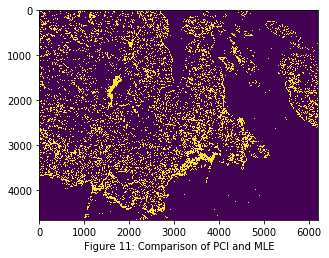

In [47]:
# McNemar Test using confustion matrix
print('Comparison between PCI MLE and scikit-learn MLE')

# MLE vs PCI
mp_table = [[mp_tp, mp_fp],
            [mp_fn, mp_tn]]
mp_result = mcnemar(mp_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (mp_result.statistic, mp_result.pvalue))
print('Contingency Table ',mp_table[0],'\n\t\t  ',mp_table[1],'\n')

# Visualize difference
mp_diff = MLE_image - mle_img
plt.figure(10,figsize=(5,5))
plt.xlabel('Figure 11: Comparison of PCI and MLE')
plt.imshow(mp_diff)

Comparison between PCI MLE and SVM - Polynomial
McNemar statistic=359.193, p-value=0.000000
Contingency Table  [62832, 420.0] 
		   [21.0, 8] 



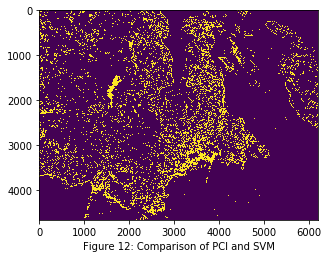

In [48]:
print('Comparison between PCI MLE and SVM - Polynomial')
# SVC vs PCI
sp_table = [[sp_tp, sp_fp],
            [sp_fn, sp_tn]]
sp_result = mcnemar(sp_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (sp_result.statistic, sp_result.pvalue))
print('Contingency Table ',sp_table[0],'\n\t\t  ',sp_table[1],'\n')

sp_diff = MLE_image - poly_img
plt.figure(12,figsize=(5,5))
plt.xlabel('Figure 12: Comparison of PCI and SVM')
plt.imshow(sp_diff)

Comparison between PCI MLE and scikit-learn Neural Network
McNemar statistic=1613.849, p-value=0.000000
Contingency Table  [60849, 142.0] 
		   [2004.0, 286] 



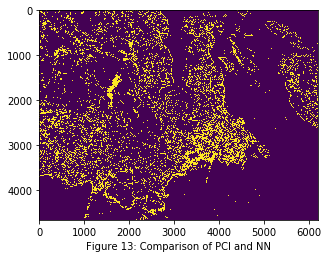

In [49]:
print('Comparison between PCI MLE and scikit-learn Neural Network')
# NN vs PCI
np_table = [[np_tp, np_fp],
            [np_fn, np_tn]]
np_result = mcnemar(np_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (np_result.statistic, np_result.pvalue))
print('Contingency Table ',np_table[0],'\n\t\t  ',np_table[1],'\n')


np_diff=MLE_image - nn_img
plt.figure(13,figsize=(5,5))
plt.xlabel('Figure 13: Comparison of PCI and NN')
plt.imshow(np_diff)

Comparison between scikit-learn MLE and SVM
McNemar statistic=2052.577, p-value=0.000000
Contingency Table  [61147, 17.0] 
		   [2105.0, 12] 



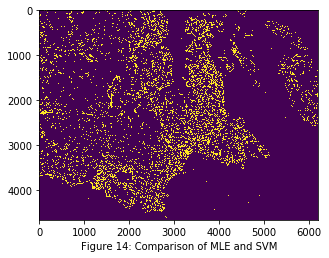

In [50]:
print('Comparison between scikit-learn MLE and SVM')
# MLE vs SVC
ms_table = [[ms_tp, ms_fp],
            [ms_fn, ms_tn]]
ms_result = mcnemar(ms_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (ms_result.statistic, ms_result.pvalue))
print('Contingency Table ',ms_table[0],'\n\t\t  ',ms_table[1],'\n')

ms_diff = mle_img - poly_img
plt.figure(14,figsize=(5,5))
plt.xlabel('Figure 14: Comparison of MLE and SVM')
plt.imshow(ms_diff)

Comparison between scikit-learn MLE and NN
McNemar statistic=12.363, p-value=0.000438
Contingency Table  [59881, 1283.0] 
		   [1110.0, 1007] 



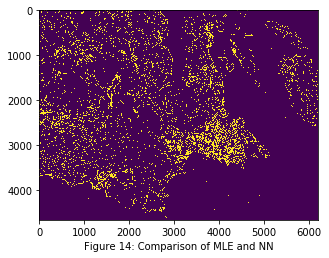

In [51]:
print('Comparison between scikit-learn MLE and NN')
# MLE vs NN
mn_table = [[mn_tp, mn_fp],
            [mn_fn, mn_tn]]
mn_result = mcnemar(mn_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (mn_result.statistic, mn_result.pvalue))
print('Contingency Table ',mn_table[0],'\n\t\t  ',mn_table[1],'\n')

mn_diff = mle_img - nn_img
plt.figure(14,figsize=(5,5))
plt.xlabel('Figure 14: Comparison of MLE and NN')
plt.imshow(mn_diff)

Comparison between scikit-learn SVM and NN
McNemar statistic=2243.127, p-value=0.000000
Contingency Table  [60983, 2269.0] 
		   [8.0, 21] 



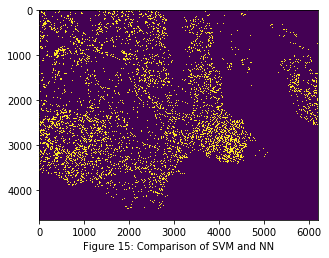

In [52]:
print('Comparison between scikit-learn SVM and NN')
# SVC vs NN
sn_table = [[sn_tp, sn_fp],
            [sn_fn, sn_tn]]
sn_result = mcnemar(sn_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (sn_result.statistic, sn_result.pvalue))
print('Contingency Table ',sn_table[0],'\n\t\t  ',sn_table[1],'\n')

sn_diff = poly_img - nn_img
plt.figure(15,figsize=(5,5))
plt.xlabel('Figure 15: Comparison of SVM and NN')
plt.imshow(sn_diff)

## 4. Conclusion



### 4.1 Hurdles and Limitations

Known ATCOR atmospheric correction did not work for the Sentinel 2A product due to the PCI software's inability to gather the metadata and atmospheric data contained within the product. For this reason an auxillary software product called Sen2Cor built for the Sentinal mission data was used, as this was unfamiliar various attempts at atmospheric correction were made to ensure that it was done correctly (Many different paramters to try).

Started with loops and list notation, but was able to use the power of numpy indexing to streamline and create more effecitve and efficient code.

Use of jupyter notebook required long run times and repetative running - maybe should have saved as an output and re-input data?

## 5. References

[1] Noi, P.T. and Kappa, M., (2018) Comparison of Random Forest, k-Nearest Neighbor, and Support Vector Machine Classifiers for 
    Land Cover Classification Using Sentinel-2 Imagery, Sensors. DOI: 10.3390/s18010018
    
[2] Frisk, J. 2011. Guidance for the preparation of ESTR products – land classification scheme. Canadian Biodiversity: 
    Ecosystem Status and Trends 2010, Technical Thematic Report No. 3. Canadian Councils of Resource Ministers. Ottawa, ON. iv + 34 p. http://www.biodivcanada.ca/default.asp?lang=En&n=137E1147-1 

Data Set: 

MetaData: 

[4] J. He, J.R. Harris, M. Sawada & P. Behnia (2015) A comparison of classification algorithms using Landsat-7 and Landsat-8 data for mapping lithology in Canada’s Arctic. International Journal of Remote Sensing. 36:8, 2252-2276, DOI: 10.1080/01431161.2015.1035410 

[5] F. Sunar Erbek , C. Özkan & M. Taberner (2004) Comparison of maximum likelihood classification method with supervised artificial neural network algorithms for land use activities. International Journal of Remote Sensing. 25:9, 1733-1748, DOI: 10.1080/0143116031000150077 

[9] Li, (2014) Comparison of Classification Algorithms and Training Sample Sizes in Urban Land Classification with Landsat Thematic Mapper Imagery. Remote Sensing, 6, 964-983; doi:10.3390/rs602096

[10] Qian, (2015) Comparing Machine Learning Classifiers for Object-Based Land Cover Classification Using Very High Resolution Imagery. Remote Sensing, 7, 153-168; doi:10.3390/rs70100153

[11] Neural Network Approaches Versus Statistical Methods in Classification of Multisource Remote Sensing Data 